In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm

In [2]:
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = [np.reshape(x, -1) for x in train_images]
test_images= [np.reshape(x, -1) for x in test_images]
train_images[0].shape

(784,)

In [4]:

def group_all_labels(data, num=100, minor=[]):
    # this function is to limit the number of labels that are used
    # it returns the indexes according the labels
    # data is an array of labels
    '''

    :param data: array of labels
    :param num: number required
    :param minor: list of minority indexes
    :return: array of labels indexes
    '''

    labels = np.unique(data)
    co_l = []
    min_col =[]
    if not minor:
        for l in labels:
            el_l = np.where(np.array(data) == l)
            co_l.append(el_l[0])

    else:
        for l in labels:
            if l in minor:
                el_l = np.where(np.array(data) == l)
                co_l.append((el_l[0])[:num])
                min_col.append((el_l[0])[:num])
            else:
                el_l = np.where(np.array(data) == l)
                co_l.append(el_l[0])
    return co_l, min_col

In [5]:
grouped_labels, min_label = group_all_labels(train_labels, 250, [0, 1])
gr_data = []
gr_labels = [] 
for index, q in enumerate(grouped_labels):
    print('class {} : number of samples : {}'.format(index,len(q)))
    for r in q:
        gr_data.append(train_images[r])
        gr_labels.append(train_labels[r])

gr_min_data = []
gr_min_labels = []

class 0 : number of samples : 250
class 1 : number of samples : 250
class 2 : number of samples : 5958
class 3 : number of samples : 6131
class 4 : number of samples : 5842
class 5 : number of samples : 5421
class 6 : number of samples : 5918
class 7 : number of samples : 6265
class 8 : number of samples : 5851
class 9 : number of samples : 5949


In [6]:
print('minority data only')
gr_min_data = []
gr_min_labels = []
for index, q in enumerate(min_label):
    print('class {} : number of samples : {}'.format(index,len(q)))
    for r in q:
        gr_min_data.append(train_images[r])
        gr_min_labels.append(train_labels[r])


minority data only
class 0 : number of samples : 250
class 1 : number of samples : 250


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


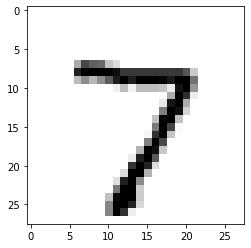

In [7]:
train_x = np.array(gr_data)
train_x = (train_x.astype(np.float32) / 255.0) 
test_x =  np.array(test_images)
test_images = (test_x.astype(np.float32)/255.0)

train_min_x = np.array(gr_min_data)
train_min_x = (train_min_x.astype(np.float32) / 255.0) 

train_y = tf.keras.utils.to_categorical(gr_labels, num_classes=10, dtype='float32')
test_y = tf.keras.utils.to_categorical(test_labels, num_classes=10, dtype='float32')
train_min_y = tf.keras.utils.to_categorical(gr_min_labels, num_classes=2, dtype='float32')

print(test_y[0])
plt.imshow(np.reshape(test_x[0],(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')

#  VAE Model

In [8]:
import tensorflow.compat.v1  as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np

mb_size = 64
z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128
lr = 1e-3


def plot(samples, sz, shape):
    fig = plt.figure(figsize=(sz, sz))
    gs = gridspec.GridSpec(sz, sz)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(shape, shape), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)


# Q(z|X) 

X = tf.keras.Input(shape=(X_dim,))
c = tf.keras.Input(shape=(y_dim,))
z = tf.keras.Input(shape=(z_dim,))

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# P(X|z)

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

# gradient step
solver = tf.compat.v1.train.AdamOptimizer().minimize(vae_loss)
sess = tf.compat.v1.Session ()
sess.run(
tf.compat.v1.global_variables_initializer())

Instructions for updating:
non-resource variables are not supported in the long term


2021-11-02 12:07:13.012427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 12:07:13.018447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-11-02 12:07:13.019177: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-02 12:07:13.019747: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

In [9]:
i = 0
for it in range(100000):
    ind = np.random.choice(train_x.shape[0], mb_size)
    X_mb = np.array(train_x[ind])
    y_mb = np.array(train_y[ind])
    
    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

In [10]:
def generate_samples():
    samples = []
    gen_labels =[]
    for r in range(62):
        for index in range(2):
            gen_labels = gen_labels + [index]*mb_size
            y = np.zeros([mb_size, y_dim])
            y[range(mb_size), index] = 1
            samples.extend(sess.run(X_samples,
                                   feed_dict={z: np.random.randn(mb_size, z_dim), c: y}))

    gen_samples = np.array(samples)
    gen_labels = np.array(gen_labels)
    print(gen_samples.shape)
    print(gen_labels.shape)
    print(gen_labels[0])
    
    return gen_samples, gen_labels

# Visualize generated samples

(7936, 784)
(7936,)
0


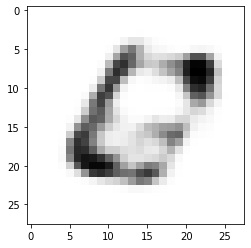

In [11]:
aug_data, aug_labels = generate_samples()
plt.imshow(np.reshape(aug_data[0],(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')

# MLP Model 

In [12]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Flatten
from tensorflow.keras.models import Sequential

def build_model(input_shape=(784,), num_classes=10):
    """

    :param input_shape: shape of input_data
    :param num_classes: number of classes
    :return: keras.model.sequential compiled with categorical cross-entropy loss
    """
    model = Sequential([
        Input(shape=input_shape),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

# Base line classification

In [18]:
def post_process_results(b_list, filename='default.csv'):
    total_df = pd.DataFrame(b_list[0]).transpose()
    print('number of runs: {}'.format(len(b_list)))
    for r_dict in b_list[1:]:
        temp = pd.DataFrame(r_dict).transpose()
        total_df = total_df.add(temp)
        
    average_pd = total_df/10.0
    average_pd.to_csv(filename, sep=',')
    
    return average_pd

In [20]:
baseline_list =[]
for i in range(10):
    bl_model = build_model()
    batch_size=64
    epochs=30
    bl_history = bl_model.fit(train_x, train_y, batch_size=batch_size,
                        epochs=epochs, validation_data=(test_images, test_y))

    bl_score = bl_model.evaluate(test_images, test_y, verbose=0)
    print('baseline test loss: ', bl_score[0])
    print('baseline test accuracy: ', bl_score[1] )

    from sklearn.metrics import classification_report
    y_pred_oh = bl_model.predict(test_images)
    y_pred_baseline = y_pred_oh.argmax(axis=-1)
    baseline_list.append(classification_report(test_labels, y_pred_baseline, output_dict=True))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                25120     
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)              

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 2s 48us/sample - loss: 0.5939 - acc: 0.8199 - val_loss: 0.4925 - val_acc: 0.8215
Epoch 2/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.2949 - acc: 0.9115 - val_loss: 0.2884 - val_acc: 0.9131
Epoch 3/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.2326 - acc: 0.9314 - val_loss: 0.2380 - val_acc: 0.9296
Epoch 4/30
47835/47835 [==============================] - 2s 43us/sample - loss: 0.2025 - acc: 0.9402 - val_loss: 0.2376 - val_acc: 0.9333
Epoch 5/30
47835/47835 [==============================] - 2s 37us/sample - loss: 0.1773 - acc: 0.9484 - val_loss: 0.1909 - val_acc: 0.9421
Epoch 6/30
47835/47835 [==============================] - 2s 37us/sample - loss: 0.1639 - acc: 0.9517 - val_loss: 0.1762 - val_acc: 0.9499
Epoch 7/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.1516 - acc: 0.9558 - val_loss: 0.1941 - val_acc: 0.9434
Epoch 8/30
47835/47835 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 2s 46us/sample - loss: 0.5886 - acc: 0.8185 - val_loss: 0.5257 - val_acc: 0.8175
Epoch 2/30
47835/47835 [==============================] - 2s 36us/sample - loss: 0.2875 - acc: 0.9154 - val_loss: 0.3038 - val_acc: 0.9073
Epoch 3/30
47835/47835 [==============================] - 2s 37us/sample - loss: 0.2349 - acc: 0.9314 - val_loss: 0.2420 - val_acc: 0.9266
Epoch 4/30
47835/47835 [==============================] - 2s 37us/sample - loss: 0.2033 - acc: 0.9391 - val_loss: 0.2170 - val_acc: 0.9341
Epoch 5/30
47835/47835 [==============================] - 2s 37us/sample - loss: 0.1787 - acc: 0.9461 - val_loss: 0.2338 - val_acc: 0.9259
Epoch 6/30
47835/47835 [==============================] - 2s 36us/sample - loss: 0.1625 - acc: 0.9519 - val_loss: 0.1888 - val_acc: 0.9441
Epoch 7/30
47835/47835 [==============================] - 2s 37us/sample - loss: 0.1533 - acc: 0.9542 - val_loss: 0.1667 - val_acc: 0.9477
Epoch 8/30
47835/47835 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 2s 49us/sample - loss: 0.5749 - acc: 0.8262 - val_loss: 0.4702 - val_acc: 0.8395
Epoch 2/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.2765 - acc: 0.9202 - val_loss: 0.3063 - val_acc: 0.9082
Epoch 3/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.2176 - acc: 0.9362 - val_loss: 0.2602 - val_acc: 0.9219
Epoch 4/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.1857 - acc: 0.9461 - val_loss: 0.2826 - val_acc: 0.9075
Epoch 5/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.1669 - acc: 0.9503 - val_loss: 0.2068 - val_acc: 0.9393
Epoch 6/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.1520 - acc: 0.9554 - val_loss: 0.1974 - val_acc: 0.9399
Epoch 7/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.1412 - acc: 0.9586 - val_loss: 0.1676 - val_acc: 0.9502
Epoch 8/30
47835/47835 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 2s 49us/sample - loss: 0.6110 - acc: 0.8141 - val_loss: 0.4612 - val_acc: 0.8432
Epoch 2/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.2890 - acc: 0.9159 - val_loss: 0.3464 - val_acc: 0.8910
Epoch 3/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.2254 - acc: 0.9337 - val_loss: 0.2884 - val_acc: 0.9125
Epoch 4/30
47835/47835 [==============================] - 2s 38us/sample - loss: 0.1961 - acc: 0.9422 - val_loss: 0.2594 - val_acc: 0.9237
Epoch 5/30
47835/47835 [==============================] - 2s 40us/sample - loss: 0.1729 - acc: 0.9481 - val_loss: 0.2274 - val_acc: 0.9280
Epoch 6/30
47835/47835 [==============================] - 2s 42us/sample - loss: 0.1539 - acc: 0.9544 - val_loss: 0.1877 - val_acc: 0.9432
Epoch 7/30
47835/47835 [==============================] - 2s 39us/sample - loss: 0.1455 - acc: 0.9558 - val_loss: 0.1872 - val_acc: 0.9437
Epoch 8/30
47835/47835 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 3s 56us/sample - loss: 0.5734 - acc: 0.8247 - val_loss: 0.5097 - val_acc: 0.8112
Epoch 2/30
47835/47835 [==============================] - 2s 45us/sample - loss: 0.2861 - acc: 0.9159 - val_loss: 0.2814 - val_acc: 0.9114
Epoch 3/30
47835/47835 [==============================] - 2s 40us/sample - loss: 0.2205 - acc: 0.9336 - val_loss: 0.2452 - val_acc: 0.9265
Epoch 4/30
47835/47835 [==============================] - 2s 40us/sample - loss: 0.1950 - acc: 0.9414 - val_loss: 0.2532 - val_acc: 0.9225
Epoch 5/30
47835/47835 [==============================] - 2s 39us/sample - loss: 0.1721 - acc: 0.9484 - val_loss: 0.2093 - val_acc: 0.9405
Epoch 6/30
47835/47835 [==============================] - 2s 39us/sample - loss: 0.1572 - acc: 0.9538 - val_loss: 0.1944 - val_acc: 0.9419
Epoch 7/30
47835/47835 [==============================] - 2s 39us/sample - loss: 0.1459 - acc: 0.9562 - val_loss: 0.1789 - val_acc: 0.9475
Epoch 8/30
47835/47835 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 2s 52us/sample - loss: 0.6056 - acc: 0.8146 - val_loss: 0.4856 - val_acc: 0.8291
Epoch 2/30
47835/47835 [==============================] - 2s 40us/sample - loss: 0.3047 - acc: 0.9090 - val_loss: 0.3886 - val_acc: 0.8645
Epoch 3/30
47835/47835 [==============================] - 2s 40us/sample - loss: 0.2388 - acc: 0.9287 - val_loss: 0.2409 - val_acc: 0.9249
Epoch 4/30
47835/47835 [==============================] - 2s 40us/sample - loss: 0.1984 - acc: 0.9416 - val_loss: 0.2444 - val_acc: 0.9256
Epoch 5/30
47835/47835 [==============================] - 2s 40us/sample - loss: 0.1750 - acc: 0.9479 - val_loss: 0.2210 - val_acc: 0.9324
Epoch 6/30
47835/47835 [==============================] - 2s 40us/sample - loss: 0.1605 - acc: 0.9520 - val_loss: 0.1645 - val_acc: 0.9472
Epoch 7/30
47835/47835 [==============================] - 2s 40us/sample - loss: 0.1468 - acc: 0.9556 - val_loss: 0.1871 - val_acc: 0.9432
Epoch 8/30
47835/47835 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 2s 48us/sample - loss: 0.5878 - acc: 0.8193 - val_loss: 0.5040 - val_acc: 0.8088
Epoch 2/30
47835/47835 [==============================] - 2s 46us/sample - loss: 0.2896 - acc: 0.9146 - val_loss: 0.3086 - val_acc: 0.8981
Epoch 3/30
47835/47835 [==============================] - 2s 49us/sample - loss: 0.2352 - acc: 0.9304 - val_loss: 0.2732 - val_acc: 0.9125
Epoch 4/30
47835/47835 [==============================] - 2s 45us/sample - loss: 0.1982 - acc: 0.9414 - val_loss: 0.2346 - val_acc: 0.9293
Epoch 5/30
47835/47835 [==============================] - 2s 45us/sample - loss: 0.1747 - acc: 0.9488 - val_loss: 0.2096 - val_acc: 0.9363
Epoch 6/30
47835/47835 [==============================] - 2s 40us/sample - loss: 0.1614 - acc: 0.9525 - val_loss: 0.1966 - val_acc: 0.9402
Epoch 7/30
47835/47835 [==============================] - 2s 41us/sample - loss: 0.1485 - acc: 0.9549 - val_loss: 0.2123 - val_acc: 0.9367
Epoch 8/30
47835/47835 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 3s 55us/sample - loss: 0.5920 - acc: 0.8226 - val_loss: 0.4770 - val_acc: 0.8426
Epoch 2/30
47835/47835 [==============================] - 2s 41us/sample - loss: 0.2878 - acc: 0.9164 - val_loss: 0.2830 - val_acc: 0.9163
Epoch 3/30
47835/47835 [==============================] - 2s 42us/sample - loss: 0.2219 - acc: 0.9348 - val_loss: 0.2462 - val_acc: 0.9253
Epoch 4/30
47835/47835 [==============================] - 2s 41us/sample - loss: 0.1893 - acc: 0.9453 - val_loss: 0.2468 - val_acc: 0.9221
Epoch 5/30
47835/47835 [==============================] - 2s 41us/sample - loss: 0.1704 - acc: 0.9495 - val_loss: 0.2286 - val_acc: 0.9298
Epoch 6/30
47835/47835 [==============================] - 2s 41us/sample - loss: 0.1576 - acc: 0.9523 - val_loss: 0.1973 - val_acc: 0.9394
Epoch 7/30
47835/47835 [==============================] - 2s 41us/sample - loss: 0.1378 - acc: 0.9589 - val_loss: 0.2016 - val_acc: 0.9408
Epoch 8/30
47835/47835 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 3s 56us/sample - loss: 0.5764 - acc: 0.8271 - val_loss: 0.4757 - val_acc: 0.8320
Epoch 2/30
47835/47835 [==============================] - 2s 43us/sample - loss: 0.2731 - acc: 0.9206 - val_loss: 0.3232 - val_acc: 0.8928
Epoch 3/30
47835/47835 [==============================] - 2s 43us/sample - loss: 0.2239 - acc: 0.9327 - val_loss: 0.2191 - val_acc: 0.9327
Epoch 4/30
47835/47835 [==============================] - 2s 43us/sample - loss: 0.1873 - acc: 0.9441 - val_loss: 0.2613 - val_acc: 0.9189
Epoch 5/30
47835/47835 [==============================] - 2s 42us/sample - loss: 0.1687 - acc: 0.9505 - val_loss: 0.1949 - val_acc: 0.9392
Epoch 6/30
47835/47835 [==============================] - 2s 42us/sample - loss: 0.1561 - acc: 0.9528 - val_loss: 0.2131 - val_acc: 0.9321
Epoch 7/30
47835/47835 [==============================] - 2s 42us/sample - loss: 0.1447 - acc: 0.9562 - val_loss: 0.2206 - val_acc: 0.9307
Epoch 8/30
47835/47835 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 3s 57us/sample - loss: 0.6321 - acc: 0.8083 - val_loss: 0.5421 - val_acc: 0.8118
Epoch 2/30
47835/47835 [==============================] - 2s 44us/sample - loss: 0.2965 - acc: 0.9121 - val_loss: 0.3740 - val_acc: 0.8757
Epoch 3/30
47835/47835 [==============================] - 2s 43us/sample - loss: 0.2325 - acc: 0.9304 - val_loss: 0.2685 - val_acc: 0.9169
Epoch 4/30
47835/47835 [==============================] - 2s 43us/sample - loss: 0.2019 - acc: 0.9392 - val_loss: 0.2324 - val_acc: 0.9283
Epoch 5/30
47835/47835 [==============================] - 2s 43us/sample - loss: 0.1783 - acc: 0.9459 - val_loss: 0.2359 - val_acc: 0.9288
Epoch 6/30
47835/47835 [==============================] - 2s 43us/sample - loss: 0.1598 - acc: 0.9510 - val_loss: 0.2280 - val_acc: 0.9293
Epoch 7/30
47835/47835 [==============================] - 2s 43us/sample - loss: 0.1489 - acc: 0.9550 - val_loss: 0.1780 - val_acc: 0.9468
Epoch 8/30
47835/47835 [==============

In [21]:
post_process_results(baseline_list, 'results_csv/mnist_baseline_cnn.csv')

number of runs: 10


,precision,recall,f1-score,support
0,0.993995,0.876327,0.931332,980.00000
1,0.997444,0.910308,0.951594,1135.00000
2,0.948296,0.973547,0.960569,1032.00000
3,0.951598,0.976139,0.963661,1010.00000
4,0.963865,0.972301,0.968026,982.00000
5,0.950770,0.963117,0.956859,892.00000
6,0.937388,0.979228,0.957680,958.00000
7,0.955625,0.969844,0.962584,1028.00000
8,0.894859,0.966016,0.928800,974.00000
9,0.958031,0.960654,0.959322,1009.00000


#  Augmentation experiment

In [22]:
results_list =[]
for i in range(10):
    gen_samples, gen_labels = generate_samples()
    X = np.concatenate([train_x, gen_samples])
    Y = np.concatenate([np.reshape(gr_labels, -1), gen_labels])

    Y_oh = np.array(tf.keras.utils.to_categorical(Y, num_classes=10, dtype='float32'))

    aug_model = build_model()
    aug_history = aug_model.fit(X, Y_oh, batch_size=batch_size,
                        epochs=epochs, validation_data=(test_images, test_y))

    aug_score = aug_model.evaluate(test_images, test_y, verbose=0)
    print('test loss for {}th run: '.format(i), aug_score[0])
    print('test accuracy for {}th run: '.format(i), aug_score[1] )
    
    y_pred_aug_oh = bl_model.predict(test_images)
    y_pred_aug = y_pred_aug_oh.argmax(axis=-1)
    results_list.append(classification_report(test_labels, y_pred_aug, output_dict=True))

(7936, 784)
(7936,)
0
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32)                25120     
_________________________________________________________________
batch_normalization_40 (Batc (None, 32)                128       
_________________________________________________________________
dense_61 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_41 (Batc (None, 64)                256       
_________________________________________________________________
flatten_20 (Flatten)         (None, 64)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)             (N

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 3s 61us/sample - loss: 0.5958 - acc: 0.8170 - val_loss: 0.2452 - val_acc: 0.9214
Epoch 2/30
55771/55771 [==============================] - 3s 50us/sample - loss: 0.2919 - acc: 0.9140 - val_loss: 0.1886 - val_acc: 0.9433
Epoch 3/30
55771/55771 [==============================] - 3s 46us/sample - loss: 0.2327 - acc: 0.9320 - val_loss: 0.1912 - val_acc: 0.9410
Epoch 4/30
55771/55771 [==============================] - 3s 46us/sample - loss: 0.2039 - acc: 0.9408 - val_loss: 0.1855 - val_acc: 0.9459
Epoch 5/30
55771/55771 [==============================] - 2s 43us/sample - loss: 0.1866 - acc: 0.9444 - val_loss: 0.1629 - val_acc: 0.9505
Epoch 6/30
55771/55771 [==============================] - 2s 44us/sample - loss: 0.1712 - acc: 0.9500 - val_loss: 0.1647 - val_acc: 0.9488
Epoch 7/30
55771/55771 [==============================] - 2s 43us/sample - loss: 0.1569 - acc: 0.9530 - val_loss: 0.1681 - val_acc: 0.9505
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 3s 57us/sample - loss: 0.5937 - acc: 0.8200 - val_loss: 0.2526 - val_acc: 0.9239
Epoch 2/30
55771/55771 [==============================] - 2s 44us/sample - loss: 0.3096 - acc: 0.9092 - val_loss: 0.2088 - val_acc: 0.9354
Epoch 3/30
55771/55771 [==============================] - 2s 43us/sample - loss: 0.2453 - acc: 0.9271 - val_loss: 0.2177 - val_acc: 0.9369
Epoch 4/30
55771/55771 [==============================] - 2s 44us/sample - loss: 0.2158 - acc: 0.9368 - val_loss: 0.1844 - val_acc: 0.9455
Epoch 5/30
55771/55771 [==============================] - 2s 44us/sample - loss: 0.1958 - acc: 0.9421 - val_loss: 0.1791 - val_acc: 0.9477
Epoch 6/30
55771/55771 [==============================] - 2s 44us/sample - loss: 0.1763 - acc: 0.9471 - val_loss: 0.1646 - val_acc: 0.9520
Epoch 7/30
55771/55771 [==============================] - 2s 44us/sample - loss: 0.1613 - acc: 0.9515 - val_loss: 0.1810 - val_acc: 0.9487
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 3s 59us/sample - loss: 0.6101 - acc: 0.8123 - val_loss: 0.2576 - val_acc: 0.9235
Epoch 2/30
55771/55771 [==============================] - 3s 46us/sample - loss: 0.3104 - acc: 0.9084 - val_loss: 0.2109 - val_acc: 0.9367
Epoch 3/30
55771/55771 [==============================] - 3s 45us/sample - loss: 0.2497 - acc: 0.9256 - val_loss: 0.1976 - val_acc: 0.9405
Epoch 4/30
55771/55771 [==============================] - 3s 46us/sample - loss: 0.2161 - acc: 0.9362 - val_loss: 0.1822 - val_acc: 0.9462
Epoch 5/30
55771/55771 [==============================] - 2s 45us/sample - loss: 0.1923 - acc: 0.9423 - val_loss: 0.1745 - val_acc: 0.9466
Epoch 6/30
55771/55771 [==============================] - 2s 45us/sample - loss: 0.1764 - acc: 0.9472 - val_loss: 0.1743 - val_acc: 0.9453
Epoch 7/30
55771/55771 [==============================] - 3s 45us/sample - loss: 0.1642 - acc: 0.9523 - val_loss: 0.1598 - val_acc: 0.9510
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 3s 60us/sample - loss: 0.6163 - acc: 0.8135 - val_loss: 0.2770 - val_acc: 0.9177
Epoch 2/30
55771/55771 [==============================] - 3s 46us/sample - loss: 0.3033 - acc: 0.9134 - val_loss: 0.2135 - val_acc: 0.9322
Epoch 3/30
55771/55771 [==============================] - 3s 46us/sample - loss: 0.2405 - acc: 0.9305 - val_loss: 0.1883 - val_acc: 0.9422
Epoch 4/30
55771/55771 [==============================] - 3s 46us/sample - loss: 0.2069 - acc: 0.9392 - val_loss: 0.2117 - val_acc: 0.9357
Epoch 5/30
55771/55771 [==============================] - 3s 45us/sample - loss: 0.1905 - acc: 0.9442 - val_loss: 0.1725 - val_acc: 0.9488
Epoch 6/30
55771/55771 [==============================] - 3s 45us/sample - loss: 0.1721 - acc: 0.9497 - val_loss: 0.1740 - val_acc: 0.9469
Epoch 7/30
55771/55771 [==============================] - 3s 45us/sample - loss: 0.1604 - acc: 0.9535 - val_loss: 0.1592 - val_acc: 0.9542
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 4s 63us/sample - loss: 0.5755 - acc: 0.8242 - val_loss: 0.2467 - val_acc: 0.9220
Epoch 2/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.2968 - acc: 0.9119 - val_loss: 0.1961 - val_acc: 0.9394
Epoch 3/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.2357 - acc: 0.9292 - val_loss: 0.1758 - val_acc: 0.9461
Epoch 4/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.2006 - acc: 0.9401 - val_loss: 0.1667 - val_acc: 0.9492
Epoch 5/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.1794 - acc: 0.9465 - val_loss: 0.1676 - val_acc: 0.9507
Epoch 6/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.1669 - acc: 0.9499 - val_loss: 0.1541 - val_acc: 0.9537
Epoch 7/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.1531 - acc: 0.9541 - val_loss: 0.1609 - val_acc: 0.9533
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 3s 63us/sample - loss: 0.5826 - acc: 0.8210 - val_loss: 0.2400 - val_acc: 0.9276
Epoch 2/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.2839 - acc: 0.9154 - val_loss: 0.1890 - val_acc: 0.9433
Epoch 3/30
55771/55771 [==============================] - 3s 48us/sample - loss: 0.2298 - acc: 0.9314 - val_loss: 0.1776 - val_acc: 0.9463
Epoch 4/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.1982 - acc: 0.9407 - val_loss: 0.1732 - val_acc: 0.9463
Epoch 5/30
55771/55771 [==============================] - 3s 48us/sample - loss: 0.1793 - acc: 0.9468 - val_loss: 0.1629 - val_acc: 0.9529
Epoch 6/30
55771/55771 [==============================] - 3s 48us/sample - loss: 0.1690 - acc: 0.9499 - val_loss: 0.1625 - val_acc: 0.9508
Epoch 7/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.1549 - acc: 0.9537 - val_loss: 0.1604 - val_acc: 0.9539
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 4s 74us/sample - loss: 0.5942 - acc: 0.8202 - val_loss: 0.2539 - val_acc: 0.9201
Epoch 2/30
55771/55771 [==============================] - 3s 49us/sample - loss: 0.2941 - acc: 0.9136 - val_loss: 0.2076 - val_acc: 0.9362
Epoch 3/30
55771/55771 [==============================] - 3s 50us/sample - loss: 0.2326 - acc: 0.9313 - val_loss: 0.1878 - val_acc: 0.9442
Epoch 4/30
55771/55771 [==============================] - 3s 48us/sample - loss: 0.2039 - acc: 0.9412 - val_loss: 0.1582 - val_acc: 0.9521
Epoch 5/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.1844 - acc: 0.9457 - val_loss: 0.1596 - val_acc: 0.9491
Epoch 6/30
55771/55771 [==============================] - 3s 48us/sample - loss: 0.1737 - acc: 0.9487 - val_loss: 0.1514 - val_acc: 0.9545
Epoch 7/30
55771/55771 [==============================] - 3s 50us/sample - loss: 0.1654 - acc: 0.9509 - val_loss: 0.1668 - val_acc: 0.9518
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 4s 78us/sample - loss: 0.6163 - acc: 0.8110 - val_loss: 0.2658 - val_acc: 0.9187
Epoch 2/30
55771/55771 [==============================] - 3s 50us/sample - loss: 0.2986 - acc: 0.9119 - val_loss: 0.2163 - val_acc: 0.9339
Epoch 3/30
55771/55771 [==============================] - 3s 58us/sample - loss: 0.2474 - acc: 0.9270 - val_loss: 0.2147 - val_acc: 0.9341
Epoch 4/30
55771/55771 [==============================] - 3s 52us/sample - loss: 0.2140 - acc: 0.9366 - val_loss: 0.1950 - val_acc: 0.9398
Epoch 5/30
55771/55771 [==============================] - 3s 49us/sample - loss: 0.1928 - acc: 0.9426 - val_loss: 0.1861 - val_acc: 0.9443
Epoch 6/30
55771/55771 [==============================] - 3s 50us/sample - loss: 0.1749 - acc: 0.9478 - val_loss: 0.1638 - val_acc: 0.9487
Epoch 7/30
55771/55771 [==============================] - 3s 49us/sample - loss: 0.1624 - acc: 0.9511 - val_loss: 0.1558 - val_acc: 0.9523
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 4s 64us/sample - loss: 0.5927 - acc: 0.8176 - val_loss: 0.2458 - val_acc: 0.9245
Epoch 2/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.2829 - acc: 0.9177 - val_loss: 0.2040 - val_acc: 0.9363
Epoch 3/30
55771/55771 [==============================] - 3s 51us/sample - loss: 0.2268 - acc: 0.9342 - val_loss: 0.1878 - val_acc: 0.9443
Epoch 4/30
55771/55771 [==============================] - 3s 48us/sample - loss: 0.1969 - acc: 0.9426 - val_loss: 0.1953 - val_acc: 0.9422
Epoch 5/30
55771/55771 [==============================] - 3s 56us/sample - loss: 0.1768 - acc: 0.9469 - val_loss: 0.1571 - val_acc: 0.9526
Epoch 6/30
55771/55771 [==============================] - 3s 49us/sample - loss: 0.1653 - acc: 0.9509 - val_loss: 0.1850 - val_acc: 0.9441
Epoch 7/30
55771/55771 [==============================] - 3s 50us/sample - loss: 0.1505 - acc: 0.9544 - val_loss: 0.1526 - val_acc: 0.9551
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 4s 72us/sample - loss: 0.5996 - acc: 0.8190 - val_loss: 0.2365 - val_acc: 0.9276
Epoch 2/30
55771/55771 [==============================] - 3s 50us/sample - loss: 0.2826 - acc: 0.9168 - val_loss: 0.2022 - val_acc: 0.9375
Epoch 3/30
55771/55771 [==============================] - 3s 49us/sample - loss: 0.2272 - acc: 0.9336 - val_loss: 0.1845 - val_acc: 0.9463
Epoch 4/30
55771/55771 [==============================] - 3s 50us/sample - loss: 0.2001 - acc: 0.9409 - val_loss: 0.1836 - val_acc: 0.9461
Epoch 5/30
55771/55771 [==============================] - 3s 50us/sample - loss: 0.1831 - acc: 0.9449 - val_loss: 0.1730 - val_acc: 0.9481
Epoch 6/30
55771/55771 [==============================] - 3s 48us/sample - loss: 0.1675 - acc: 0.9498 - val_loss: 0.1624 - val_acc: 0.9531
Epoch 7/30
55771/55771 [==============================] - 3s 47us/sample - loss: 0.1538 - acc: 0.9549 - val_loss: 0.1601 - val_acc: 0.9541
Epoch 8/30
55771/55771 [==============

In [23]:
post_process_results(results_list, 'results_csv/mnist_VAE.csv')

number of runs: 10


,precision,recall,f1-score,support
0,0.993158,0.888776,0.938072,980.0000
1,0.995256,0.924229,0.958429,1135.0000
2,0.951932,0.978682,0.965122,1032.0000
3,0.955426,0.976238,0.965720,1010.0000
4,0.973469,0.971487,0.972477,982.0000
5,0.947137,0.964126,0.955556,892.0000
6,0.917315,0.984342,0.949648,958.0000
7,0.973581,0.967899,0.970732,1028.0000
8,0.906008,0.959959,0.932203,974.0000
9,0.963221,0.960357,0.961787,1009.0000


# Random UnderSmapling

In [24]:
undersampling_list =[]
for i in range(10):
    bl_model = build_model()
    batch_size=64
    epochs=30
    
    rus = RandomUnderSampler(random_state=42)
    X_train, y_train1 = rus.fit_resample(train_x, train_y)
    
    bl_history = bl_model.fit(X_train, y_train1, batch_size=batch_size,
                        epochs=epochs, validation_data=(test_images, test_y))

    bl_score = bl_model.evaluate(test_images, test_y, verbose=0)
    print('undersampling test loss: ', bl_score[0])
    print('undersampling accuracy: ', bl_score[1] )

    from sklearn.metrics import classification_report
    y_pred_oh = bl_model.predict(test_images)
    y_pred_baseline = y_pred_oh.argmax(axis=-1)
    undersampling_list.append(classification_report(test_labels, y_pred_baseline, output_dict=True))

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 32)                25120     
_________________________________________________________________
batch_normalization_60 (Batc (None, 32)                128       
_________________________________________________________________
dense_91 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_61 (Batc (None, 64)                256       
_________________________________________________________________
flatten_30 (Flatten)         (None, 64)                0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 10)              

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2500/2500 [==============================] - 1s 524us/sample - loss: 2.1040 - acc: 0.3512 - val_loss: 1.7635 - val_acc: 0.5809
Epoch 2/30
2500/2500 [==============================] - 0s 146us/sample - loss: 1.1332 - acc: 0.6256 - val_loss: 1.3408 - val_acc: 0.7369
Epoch 3/30
2500/2500 [==============================] - 0s 148us/sample - loss: 0.8479 - acc: 0.7312 - val_loss: 0.9910 - val_acc: 0.8116
Epoch 4/30
2500/2500 [==============================] - 0s 163us/sample - loss: 0.7122 - acc: 0.7764 - val_loss: 0.7369 - val_acc: 0.8476
Epoch 5/30
2500/2500 [==============================] - 0s 166us/sample - loss: 0.6120 - acc: 0.8088 - val_loss: 0.5964 - val_acc: 0.8617
Epoch 6/30
2500/2500 [==============================] - 0s 159us/sample - loss: 0.5582 - acc: 0.8340 - val_loss: 0.5067 - val_acc: 0.8735
Epoch 7/30
2500/2500 [==============================] - 0s 183us/sample - loss: 0.5018 - acc: 0.8496 - val_loss: 0.4239 - val_acc: 0.8888
Epoch 8/30
2500/2500 [=======================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2500/2500 [==============================] - 1s 595us/sample - loss: 2.0635 - acc: 0.3508 - val_loss: 1.8096 - val_acc: 0.5242
Epoch 2/30
2500/2500 [==============================] - 0s 162us/sample - loss: 1.1649 - acc: 0.6244 - val_loss: 1.4464 - val_acc: 0.7274
Epoch 3/30
2500/2500 [==============================] - 0s 177us/sample - loss: 0.8786 - acc: 0.7168 - val_loss: 1.0929 - val_acc: 0.8135
Epoch 4/30
2500/2500 [==============================] - 0s 162us/sample - loss: 0.6985 - acc: 0.7888 - val_loss: 0.8209 - val_acc: 0.8462
Epoch 5/30
2500/2500 [==============================] - 0s 150us/sample - loss: 0.6134 - acc: 0.8136 - val_loss: 0.6218 - val_acc: 0.8666
Epoch 6/30
2500/2500 [==============================] - 0s 170us/sample - loss: 0.5404 - acc: 0.8404 - val_loss: 0.5083 - val_acc: 0.8782
Epoch 7/30
2500/2500 [==============================] - 0s 155us/sample - loss: 0.4637 - acc: 0.8652 - val_loss: 0.4478 - val_acc: 0.8808
Epoch 8/30
2500/2500 [=======================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2500/2500 [==============================] - 1s 567us/sample - loss: 2.1260 - acc: 0.3744 - val_loss: 1.8166 - val_acc: 0.6210
Epoch 2/30
2500/2500 [==============================] - 0s 157us/sample - loss: 1.0659 - acc: 0.6580 - val_loss: 1.3829 - val_acc: 0.7267
Epoch 3/30
2500/2500 [==============================] - 0s 154us/sample - loss: 0.7673 - acc: 0.7540 - val_loss: 1.0062 - val_acc: 0.8244
Epoch 4/30
2500/2500 [==============================] - 0s 160us/sample - loss: 0.6217 - acc: 0.8088 - val_loss: 0.7397 - val_acc: 0.8515
Epoch 5/30
2500/2500 [==============================] - 0s 154us/sample - loss: 0.5265 - acc: 0.8416 - val_loss: 0.5659 - val_acc: 0.8728
Epoch 6/30
2500/2500 [==============================] - 0s 167us/sample - loss: 0.4808 - acc: 0.8524 - val_loss: 0.4605 - val_acc: 0.8798
Epoch 7/30
2500/2500 [==============================] - 0s 157us/sample - loss: 0.4276 - acc: 0.8700 - val_loss: 0.4112 - val_acc: 0.8822
Epoch 8/30
2500/2500 [=======================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2500/2500 [==============================] - 2s 628us/sample - loss: 2.1267 - acc: 0.3448 - val_loss: 1.8420 - val_acc: 0.4671
Epoch 2/30
2500/2500 [==============================] - 0s 155us/sample - loss: 1.1181 - acc: 0.6212 - val_loss: 1.3695 - val_acc: 0.7401
Epoch 3/30
2500/2500 [==============================] - 0s 157us/sample - loss: 0.8244 - acc: 0.7284 - val_loss: 1.0135 - val_acc: 0.8224
Epoch 4/30
2500/2500 [==============================] - 0s 159us/sample - loss: 0.6729 - acc: 0.7868 - val_loss: 0.7274 - val_acc: 0.8577
Epoch 5/30
2500/2500 [==============================] - 0s 170us/sample - loss: 0.5624 - acc: 0.8324 - val_loss: 0.5625 - val_acc: 0.8749
Epoch 6/30
2500/2500 [==============================] - 0s 163us/sample - loss: 0.4920 - acc: 0.8488 - val_loss: 0.4514 - val_acc: 0.8870
Epoch 7/30
2500/2500 [==============================] - 0s 158us/sample - loss: 0.4498 - acc: 0.8724 - val_loss: 0.4078 - val_acc: 0.8917
Epoch 8/30
2500/2500 [=======================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2500/2500 [==============================] - 2s 719us/sample - loss: 2.1296 - acc: 0.3416 - val_loss: 1.8583 - val_acc: 0.4737
Epoch 2/30
2500/2500 [==============================] - 0s 173us/sample - loss: 1.1197 - acc: 0.6156 - val_loss: 1.4580 - val_acc: 0.7137
Epoch 3/30
2500/2500 [==============================] - 0s 196us/sample - loss: 0.8012 - acc: 0.7448 - val_loss: 1.0516 - val_acc: 0.8351
Epoch 4/30
2500/2500 [==============================] - 0s 187us/sample - loss: 0.6239 - acc: 0.8064 - val_loss: 0.7449 - val_acc: 0.8645
Epoch 5/30
2500/2500 [==============================] - 0s 173us/sample - loss: 0.5369 - acc: 0.8408 - val_loss: 0.5772 - val_acc: 0.8735
Epoch 6/30
2500/2500 [==============================] - 0s 163us/sample - loss: 0.4730 - acc: 0.8536 - val_loss: 0.4724 - val_acc: 0.8867
Epoch 7/30
2500/2500 [==============================] - 0s 171us/sample - loss: 0.4261 - acc: 0.8692 - val_loss: 0.3851 - val_acc: 0.8955
Epoch 8/30
2500/2500 [=======================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2500/2500 [==============================] - 2s 670us/sample - loss: 2.0049 - acc: 0.3784 - val_loss: 1.7380 - val_acc: 0.6092
Epoch 2/30
2500/2500 [==============================] - 0s 183us/sample - loss: 1.0793 - acc: 0.6516 - val_loss: 1.3327 - val_acc: 0.7851
Epoch 3/30
2500/2500 [==============================] - 0s 171us/sample - loss: 0.7972 - acc: 0.7484 - val_loss: 0.9749 - val_acc: 0.8378
Epoch 4/30
2500/2500 [==============================] - 0s 170us/sample - loss: 0.6713 - acc: 0.7864 - val_loss: 0.7138 - val_acc: 0.8617
Epoch 5/30
2500/2500 [==============================] - 1s 209us/sample - loss: 0.5628 - acc: 0.8224 - val_loss: 0.5638 - val_acc: 0.8762
Epoch 6/30
2500/2500 [==============================] - 0s 173us/sample - loss: 0.4999 - acc: 0.8440 - val_loss: 0.4762 - val_acc: 0.8793
Epoch 7/30
2500/2500 [==============================] - 0s 172us/sample - loss: 0.4688 - acc: 0.8676 - val_loss: 0.3984 - val_acc: 0.8897
Epoch 8/30
2500/2500 [=======================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2500/2500 [==============================] - 2s 799us/sample - loss: 2.1981 - acc: 0.3360 - val_loss: 1.9242 - val_acc: 0.5963
Epoch 2/30
2500/2500 [==============================] - 1s 277us/sample - loss: 1.2093 - acc: 0.6104 - val_loss: 1.5194 - val_acc: 0.7444
Epoch 3/30
2500/2500 [==============================] - 0s 194us/sample - loss: 0.8851 - acc: 0.7136 - val_loss: 1.1499 - val_acc: 0.8112
Epoch 4/30
2500/2500 [==============================] - 0s 181us/sample - loss: 0.7031 - acc: 0.7824 - val_loss: 0.8625 - val_acc: 0.8530
Epoch 5/30
2500/2500 [==============================] - 0s 194us/sample - loss: 0.6067 - acc: 0.8188 - val_loss: 0.6308 - val_acc: 0.8759
Epoch 6/30
2500/2500 [==============================] - 1s 219us/sample - loss: 0.5164 - acc: 0.8484 - val_loss: 0.5094 - val_acc: 0.8835
Epoch 7/30
2500/2500 [==============================] - 1s 221us/sample - loss: 0.4615 - acc: 0.8648 - val_loss: 0.4183 - val_acc: 0.8951
Epoch 8/30
2500/2500 [=======================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2500/2500 [==============================] - 2s 626us/sample - loss: 2.1637 - acc: 0.3384 - val_loss: 1.8132 - val_acc: 0.6802
Epoch 2/30
2500/2500 [==============================] - 0s 160us/sample - loss: 1.1288 - acc: 0.6384 - val_loss: 1.4083 - val_acc: 0.7777
Epoch 3/30
2500/2500 [==============================] - 0s 166us/sample - loss: 0.8259 - acc: 0.7344 - val_loss: 1.0490 - val_acc: 0.8285
Epoch 4/30
2500/2500 [==============================] - 0s 164us/sample - loss: 0.6853 - acc: 0.7920 - val_loss: 0.7787 - val_acc: 0.8477
Epoch 5/30
2500/2500 [==============================] - 0s 161us/sample - loss: 0.6029 - acc: 0.8204 - val_loss: 0.6198 - val_acc: 0.8614
Epoch 6/30
2500/2500 [==============================] - 0s 166us/sample - loss: 0.5444 - acc: 0.8380 - val_loss: 0.5056 - val_acc: 0.8709
Epoch 7/30
2500/2500 [==============================] - 0s 164us/sample - loss: 0.4983 - acc: 0.8524 - val_loss: 0.4557 - val_acc: 0.8751
Epoch 8/30
2500/2500 [=======================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2500/2500 [==============================] - 2s 634us/sample - loss: 2.2872 - acc: 0.3056 - val_loss: 1.9140 - val_acc: 0.5326
Epoch 2/30
2500/2500 [==============================] - 0s 168us/sample - loss: 1.2162 - acc: 0.5964 - val_loss: 1.5020 - val_acc: 0.7490
Epoch 3/30
2500/2500 [==============================] - 0s 167us/sample - loss: 0.8952 - acc: 0.7168 - val_loss: 1.1053 - val_acc: 0.8274
Epoch 4/30
2500/2500 [==============================] - 0s 165us/sample - loss: 0.7072 - acc: 0.7844 - val_loss: 0.8181 - val_acc: 0.8529
Epoch 5/30
2500/2500 [==============================] - 0s 166us/sample - loss: 0.5929 - acc: 0.8200 - val_loss: 0.6091 - val_acc: 0.8690
Epoch 6/30
2500/2500 [==============================] - 0s 166us/sample - loss: 0.5156 - acc: 0.8460 - val_loss: 0.4784 - val_acc: 0.8831
Epoch 7/30
2500/2500 [==============================] - 0s 165us/sample - loss: 0.4353 - acc: 0.8652 - val_loss: 0.4073 - val_acc: 0.8934
Epoch 8/30
2500/2500 [=======================

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2500/2500 [==============================] - 2s 650us/sample - loss: 2.0604 - acc: 0.3604 - val_loss: 1.7823 - val_acc: 0.5810
Epoch 2/30
2500/2500 [==============================] - 0s 168us/sample - loss: 1.1133 - acc: 0.6356 - val_loss: 1.4027 - val_acc: 0.7176
Epoch 3/30
2500/2500 [==============================] - 0s 173us/sample - loss: 0.8310 - acc: 0.7408 - val_loss: 1.0509 - val_acc: 0.8162
Epoch 4/30
2500/2500 [==============================] - 0s 170us/sample - loss: 0.6746 - acc: 0.7948 - val_loss: 0.7783 - val_acc: 0.8537
Epoch 5/30
2500/2500 [==============================] - 0s 169us/sample - loss: 0.5854 - acc: 0.8224 - val_loss: 0.5865 - val_acc: 0.8768
Epoch 6/30
2500/2500 [==============================] - 0s 166us/sample - loss: 0.4907 - acc: 0.8492 - val_loss: 0.4924 - val_acc: 0.8817
Epoch 7/30
2500/2500 [==============================] - 0s 166us/sample - loss: 0.4582 - acc: 0.8612 - val_loss: 0.4279 - val_acc: 0.8900
Epoch 8/30
2500/2500 [=======================

In [25]:
post_process_results(undersampling_list, 'results_csv/mnist_undersampling.csv')

number of runs: 10


,precision,recall,f1-score,support
0,0.938053,0.960000,0.948713,980.00000
1,0.968414,0.965991,0.967101,1135.00000
2,0.921075,0.874128,0.896311,1032.00000
3,0.891500,0.884653,0.887797,1010.00000
4,0.886977,0.920570,0.902655,982.00000
5,0.877994,0.868049,0.872619,892.00000
6,0.905320,0.944885,0.924225,958.00000
7,0.931264,0.895039,0.912391,1028.00000
8,0.881879,0.832546,0.854881,974.00000
9,0.855928,0.896531,0.873564,1009.00000


# Random OverSampling

In [26]:
oversampling_list =[]
for i in range(10):
    bl_model = build_model()
    batch_size=64
    epochs=30
    
    rus = RandomOverSampler(random_state=42)
    X_train, y_train1 = rus.fit_resample(train_x, train_y)
    
    bl_history = bl_model.fit(X_train, y_train1, batch_size=batch_size,
                        epochs=epochs, validation_data=(test_images, test_y))

    bl_score = bl_model.evaluate(test_images, test_y, verbose=0)
    print('oversampling test loss: ', bl_score[0])
    print('oversampling accuracy: ', bl_score[1] )

    from sklearn.metrics import classification_report
    y_pred_oh = bl_model.predict(test_images)
    y_pred_baseline = y_pred_oh.argmax(axis=-1)
    oversampling_list.append(classification_report(test_labels, y_pred_baseline, output_dict=True))

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 32)                25120     
_________________________________________________________________
batch_normalization_80 (Batc (None, 32)                128       
_________________________________________________________________
dense_121 (Dense)            (None, 64)                2112      
_________________________________________________________________
batch_normalization_81 (Batc (None, 64)                256       
_________________________________________________________________
flatten_40 (Flatten)         (None, 64)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 10)              

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


62650/62650 [==============================] - 5s 77us/sample - loss: 0.4972 - acc: 0.8505 - val_loss: 0.2235 - val_acc: 0.9292
Epoch 2/30
62650/62650 [==============================] - 4s 56us/sample - loss: 0.2316 - acc: 0.9332 - val_loss: 0.1836 - val_acc: 0.9454
Epoch 3/30
62650/62650 [==============================] - 4s 64us/sample - loss: 0.1859 - acc: 0.9456 - val_loss: 0.1609 - val_acc: 0.9535
Epoch 4/30
62650/62650 [==============================] - 4s 63us/sample - loss: 0.1543 - acc: 0.9557 - val_loss: 0.1707 - val_acc: 0.9507
Epoch 5/30
62650/62650 [==============================] - 4s 62us/sample - loss: 0.1362 - acc: 0.9611 - val_loss: 0.2041 - val_acc: 0.9435
Epoch 6/30
62650/62650 [==============================] - 4s 66us/sample - loss: 0.1262 - acc: 0.9627 - val_loss: 0.1659 - val_acc: 0.9535
Epoch 7/30
62650/62650 [==============================] - 4s 64us/sample - loss: 0.1146 - acc: 0.9664 - val_loss: 0.2112 - val_acc: 0.9450
Epoch 8/30
62650/62650 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


62650/62650 [==============================] - 5s 81us/sample - loss: 0.5157 - acc: 0.8437 - val_loss: 0.2254 - val_acc: 0.9315
Epoch 2/30
62650/62650 [==============================] - 4s 58us/sample - loss: 0.2483 - acc: 0.9276 - val_loss: 0.1982 - val_acc: 0.9401
Epoch 3/30
62650/62650 [==============================] - 4s 58us/sample - loss: 0.1953 - acc: 0.9418 - val_loss: 0.1632 - val_acc: 0.9511
Epoch 4/30
62650/62650 [==============================] - 4s 57us/sample - loss: 0.1701 - acc: 0.9483 - val_loss: 0.1877 - val_acc: 0.9428
Epoch 5/30
62650/62650 [==============================] - 4s 58us/sample - loss: 0.1556 - acc: 0.9542 - val_loss: 0.1656 - val_acc: 0.9528
Epoch 6/30
62650/62650 [==============================] - 4s 58us/sample - loss: 0.1431 - acc: 0.9576 - val_loss: 0.1518 - val_acc: 0.9541
Epoch 7/30
62650/62650 [==============================] - 4s 59us/sample - loss: 0.1286 - acc: 0.9601 - val_loss: 0.1689 - val_acc: 0.9509
Epoch 8/30
62650/62650 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


62650/62650 [==============================] - 5s 80us/sample - loss: 0.5244 - acc: 0.8424 - val_loss: 0.2094 - val_acc: 0.9345
Epoch 2/30
62650/62650 [==============================] - 4s 58us/sample - loss: 0.2427 - acc: 0.9291 - val_loss: 0.1833 - val_acc: 0.9427
Epoch 3/30
62650/62650 [==============================] - 4s 59us/sample - loss: 0.1930 - acc: 0.9429 - val_loss: 0.1767 - val_acc: 0.9471
Epoch 4/30
62650/62650 [==============================] - 4s 58us/sample - loss: 0.1632 - acc: 0.9520 - val_loss: 0.1722 - val_acc: 0.9502
Epoch 5/30
62650/62650 [==============================] - 4s 58us/sample - loss: 0.1461 - acc: 0.9570 - val_loss: 0.1566 - val_acc: 0.9558
Epoch 6/30
62650/62650 [==============================] - 4s 58us/sample - loss: 0.1325 - acc: 0.9613 - val_loss: 0.1655 - val_acc: 0.9547
Epoch 7/30
62650/62650 [==============================] - 4s 58us/sample - loss: 0.1245 - acc: 0.9633 - val_loss: 0.1637 - val_acc: 0.9545
Epoch 8/30
62650/62650 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


62650/62650 [==============================] - 6s 96us/sample - loss: 0.5303 - acc: 0.8404 - val_loss: 0.2361 - val_acc: 0.9292
Epoch 2/30
62650/62650 [==============================] - 4s 65us/sample - loss: 0.2358 - acc: 0.9317 - val_loss: 0.1728 - val_acc: 0.9473
Epoch 3/30
62650/62650 [==============================] - 4s 62us/sample - loss: 0.1945 - acc: 0.9430 - val_loss: 0.1607 - val_acc: 0.9513
Epoch 4/30
62650/62650 [==============================] - 4s 64us/sample - loss: 0.1639 - acc: 0.9521 - val_loss: 0.1688 - val_acc: 0.9511
Epoch 5/30
62650/62650 [==============================] - 4s 60us/sample - loss: 0.1489 - acc: 0.9564 - val_loss: 0.1692 - val_acc: 0.9518
Epoch 6/30
62650/62650 [==============================] - 4s 71us/sample - loss: 0.1364 - acc: 0.9595 - val_loss: 0.1498 - val_acc: 0.9573
Epoch 7/30
62650/62650 [==============================] - 4s 60us/sample - loss: 0.1238 - acc: 0.9637 - val_loss: 0.1446 - val_acc: 0.9596
Epoch 8/30
62650/62650 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


62650/62650 [==============================] - 5s 84us/sample - loss: 0.5227 - acc: 0.8433 - val_loss: 0.2157 - val_acc: 0.9321
Epoch 2/30
62650/62650 [==============================] - 4s 68us/sample - loss: 0.2368 - acc: 0.9310 - val_loss: 0.1816 - val_acc: 0.9449
Epoch 3/30
62650/62650 [==============================] - 4s 56us/sample - loss: 0.1866 - acc: 0.9450 - val_loss: 0.1854 - val_acc: 0.9446
Epoch 4/30
62650/62650 [==============================] - 3s 52us/sample - loss: 0.1585 - acc: 0.9540 - val_loss: 0.1746 - val_acc: 0.9486
Epoch 5/30
62650/62650 [==============================] - 3s 52us/sample - loss: 0.1443 - acc: 0.9584 - val_loss: 0.1687 - val_acc: 0.9502
Epoch 6/30
62650/62650 [==============================] - 3s 53us/sample - loss: 0.1301 - acc: 0.9621 - val_loss: 0.1621 - val_acc: 0.9545
Epoch 7/30
62650/62650 [==============================] - 3s 52us/sample - loss: 0.1181 - acc: 0.9644 - val_loss: 0.1629 - val_acc: 0.9555
Epoch 8/30
62650/62650 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


62650/62650 [==============================] - 5s 74us/sample - loss: 0.5316 - acc: 0.8406 - val_loss: 0.2193 - val_acc: 0.9344
Epoch 2/30
62650/62650 [==============================] - 3s 52us/sample - loss: 0.2412 - acc: 0.9302 - val_loss: 0.1726 - val_acc: 0.9491
Epoch 3/30
62650/62650 [==============================] - 3s 52us/sample - loss: 0.1897 - acc: 0.9445 - val_loss: 0.1692 - val_acc: 0.9512
Epoch 4/30
62650/62650 [==============================] - 3s 52us/sample - loss: 0.1641 - acc: 0.9521 - val_loss: 0.1701 - val_acc: 0.9521
Epoch 5/30
62650/62650 [==============================] - 3s 52us/sample - loss: 0.1456 - acc: 0.9576 - val_loss: 0.1508 - val_acc: 0.9575
Epoch 6/30
62650/62650 [==============================] - 3s 52us/sample - loss: 0.1359 - acc: 0.9604 - val_loss: 0.1869 - val_acc: 0.9478
Epoch 7/30
62650/62650 [==============================] - 3s 51us/sample - loss: 0.1260 - acc: 0.9638 - val_loss: 0.1597 - val_acc: 0.9562
Epoch 8/30
62650/62650 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


62650/62650 [==============================] - 5s 74us/sample - loss: 0.5329 - acc: 0.8410 - val_loss: 0.2184 - val_acc: 0.9337
Epoch 2/30
62650/62650 [==============================] - 3s 53us/sample - loss: 0.2396 - acc: 0.9309 - val_loss: 0.1792 - val_acc: 0.9446
Epoch 3/30
62650/62650 [==============================] - 3s 54us/sample - loss: 0.1872 - acc: 0.9461 - val_loss: 0.1563 - val_acc: 0.9526
Epoch 4/30
62650/62650 [==============================] - 3s 52us/sample - loss: 0.1567 - acc: 0.9542 - val_loss: 0.1486 - val_acc: 0.9552
Epoch 5/30
62650/62650 [==============================] - 3s 53us/sample - loss: 0.1381 - acc: 0.9597 - val_loss: 0.1456 - val_acc: 0.9576
Epoch 6/30
62650/62650 [==============================] - 3s 53us/sample - loss: 0.1269 - acc: 0.9631 - val_loss: 0.1555 - val_acc: 0.9554
Epoch 7/30
62650/62650 [==============================] - 3s 53us/sample - loss: 0.1143 - acc: 0.9660 - val_loss: 0.1474 - val_acc: 0.9583
Epoch 8/30
62650/62650 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


62650/62650 [==============================] - 5s 75us/sample - loss: 0.5081 - acc: 0.8474 - val_loss: 0.2280 - val_acc: 0.9294
Epoch 2/30
62650/62650 [==============================] - 3s 53us/sample - loss: 0.2333 - acc: 0.9334 - val_loss: 0.1802 - val_acc: 0.9452
Epoch 3/30
62650/62650 [==============================] - 3s 53us/sample - loss: 0.1808 - acc: 0.9478 - val_loss: 0.1460 - val_acc: 0.9575
Epoch 4/30
62650/62650 [==============================] - 3s 53us/sample - loss: 0.1589 - acc: 0.9552 - val_loss: 0.1427 - val_acc: 0.9582
Epoch 5/30
62650/62650 [==============================] - 4s 58us/sample - loss: 0.1361 - acc: 0.9605 - val_loss: 0.1364 - val_acc: 0.9597
Epoch 6/30
62650/62650 [==============================] - 4s 66us/sample - loss: 0.1282 - acc: 0.9635 - val_loss: 0.1498 - val_acc: 0.9585
Epoch 7/30
62650/62650 [==============================] - 4s 61us/sample - loss: 0.1174 - acc: 0.9660 - val_loss: 0.1359 - val_acc: 0.9604
Epoch 8/30
62650/62650 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


62650/62650 [==============================] - 5s 85us/sample - loss: 0.5139 - acc: 0.8446 - val_loss: 0.2017 - val_acc: 0.9372
Epoch 2/30
62650/62650 [==============================] - 4s 62us/sample - loss: 0.2428 - acc: 0.9293 - val_loss: 0.1771 - val_acc: 0.9462
Epoch 3/30
62650/62650 [==============================] - 4s 63us/sample - loss: 0.1955 - acc: 0.9424 - val_loss: 0.1820 - val_acc: 0.9459
Epoch 4/30
62650/62650 [==============================] - 4s 62us/sample - loss: 0.1647 - acc: 0.9513 - val_loss: 0.1660 - val_acc: 0.9515
Epoch 5/30
62650/62650 [==============================] - 4s 62us/sample - loss: 0.1459 - acc: 0.9575 - val_loss: 0.1811 - val_acc: 0.9493
Epoch 6/30
62650/62650 [==============================] - 4s 62us/sample - loss: 0.1338 - acc: 0.9597 - val_loss: 0.1573 - val_acc: 0.9539
Epoch 7/30
62650/62650 [==============================] - 4s 63us/sample - loss: 0.1232 - acc: 0.9641 - val_loss: 0.1575 - val_acc: 0.9559
Epoch 8/30
62650/62650 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


62650/62650 [==============================] - 5s 86us/sample - loss: 0.5033 - acc: 0.8498 - val_loss: 0.2183 - val_acc: 0.9330
Epoch 2/30
62650/62650 [==============================] - 4s 63us/sample - loss: 0.2313 - acc: 0.9329 - val_loss: 0.1647 - val_acc: 0.9497
Epoch 3/30
62650/62650 [==============================] - 4s 64us/sample - loss: 0.1777 - acc: 0.9487 - val_loss: 0.1559 - val_acc: 0.9559
Epoch 4/30
62650/62650 [==============================] - 4s 63us/sample - loss: 0.1492 - acc: 0.9567 - val_loss: 0.1507 - val_acc: 0.9568
Epoch 5/30
62650/62650 [==============================] - 4s 63us/sample - loss: 0.1302 - acc: 0.9617 - val_loss: 0.1544 - val_acc: 0.9569
Epoch 6/30
62650/62650 [==============================] - 4s 68us/sample - loss: 0.1215 - acc: 0.9636 - val_loss: 0.1358 - val_acc: 0.9627
Epoch 7/30
62650/62650 [==============================] - 4s 64us/sample - loss: 0.1086 - acc: 0.9675 - val_loss: 0.1493 - val_acc: 0.9590
Epoch 8/30
62650/62650 [==============

In [27]:
post_process_results(oversampling_list, 'results_csv/mnist_oversampling.csv')

number of runs: 10


,precision,recall,f1-score,support
0,0.992434,0.922347,0.956056,980.00000
1,0.996169,0.937093,0.965641,1135.00000
2,0.959189,0.974709,0.966845,1032.00000
3,0.953741,0.969802,0.961623,1010.00000
4,0.964108,0.969857,0.966927,982.00000
5,0.944908,0.962892,0.953676,892.00000
6,0.953888,0.977453,0.965486,958.00000
7,0.962812,0.968969,0.965796,1028.00000
8,0.922545,0.962628,0.941973,974.00000
9,0.953157,0.958276,0.955641,1009.00000
